In [1]:
import json
import pandas as pd
import re

In [2]:
def wrap_countries(country_dict):
    return json.dumps(
        {
            'countries': country_dict
        }
    )

In [3]:
def build_variant_dict(variants):
    variant_dict = {}
    for variant in variants:
        if '(' in variant:
            base_string = variant[variant.find('(') + 1 : variant.find(')')]
            variant_dict[variant] = base_string.split('+')
        else:
            variant_dict[variant] = []
    return variant_dict

In [4]:
def match_variant(lineage_val):
    for key, val in variant_dict.items():
        for regex in val:
            if re.search(r'%s' % regex, lineage_val):
                return regex
    return ''

In [5]:
def add_subvariants(variant_dict, df):
    for key, val in variant_dict.items():
        row = df[df['variant'] == key]
        df.append([row]*len(val), ignore_index=True)
        
        indexes = df.index[df['variant'] == key].tolist()
        for subvariant, index in zip(val, indexes):
            print('adding subvariant:', subvariant, 'at index', index)
            df.loc[index]['subvariant'] = subvariant

In [6]:
def subvariants(variant_dict):
#     df = pd.DataFrame()
    items = []
    for key, val in variant_dict.items():
        for subvariant in val:
            items.append({
                'variant': key,
                'subvariant': subvariant
            })
    return pd.DataFrame(items)

In [7]:
data = pd.read_json('~/Downloads/gisaid_variants_statistics_2022_04_11_0054/gisaid_variants_statistics.json')

In [8]:
data['countries'] = data.stats.apply(wrap_countries)

In [9]:
result_df = pd.DataFrame()

In [10]:
for index, row in data.iterrows():
    value = json.loads(row.countries)
    if 'USA' not in value['countries']:
        continue
    
    usa = value['countries']['USA']
    
    lineage_df = pd.json_normalize(
        usa, 
        record_path = ['submissions_per_lineage']
    )
    
    lineage_df.rename(
        columns = {
            'count': 'lineage_count', 
            'value': 'lineage'
        }, inplace = True
    )
    
    if len(lineage_df.index) == 0:
        continue
    
    variant_df = pd.json_normalize(
        usa, 
        record_path = ['submissions_per_variant'],
        meta=[
            'submissions'
        ]
    )
    
    variant_df.rename(
        columns = {
            'count': 'variant_count', 
            'value': 'variant',
            'submissions': 'submission_count'
        }, inplace = True
    )
    
    vals = variant_df.variant.values.tolist()
    variant_dict = build_variant_dict(vals)
    subvariant_df = subvariants(variant_dict)
    if len(subvariant_df.index) == 0:
        continue
        
    variant_df = variant_df.merge(subvariant_df, left_on='variant', right_on='variant')
    lineage_df['lineage_variant'] = lineage_df.lineage.apply(match_variant)
    
    full_variant_df = variant_df.merge(lineage_df, how='outer', left_on='subvariant', right_on='lineage_variant')
    full_variant_df.drop(columns=['lineage_variant'], inplace=True)
    full_variant_df['date'] = index
    
    result_df = result_df.append(full_variant_df)

In [11]:
result_df.sample(30)

,variant_count,variant,submission_count,subvariant,lineage_count,lineage,date
39,66701.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,67446,AY.*,96.0,AY.43,2021-08-15
18,65418.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,66430,AY.*,509.0,AY.113,2021-12-05
76,60186.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,60437,AY.*,7.0,AY.7.1,2021-11-07
8,72353.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,72858,AY.*,2275.0,AY.39,2021-09-12
31,65705.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,66163,AY.*,137.0,AY.13,2021-09-19
2,5098.0,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,22306,Q.*,12.0,Q.4,2021-03-07
52,876.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,18067,AY.*,1.0,AY.45,2021-05-23
43,62489.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,62846,AY.*,60.0,AY.125,2021-11-14
85,42711.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,72909,AY.*,4.0,AY.124,2021-12-19
30,69529.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,71807,AY.*,225.0,AY.39.1,2021-08-01


In [12]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6265 entries, 0 to 4
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   variant_count     6090 non-null   float64       
 1   variant           6090 non-null   object        
 2   submission_count  6090 non-null   object        
 3   subvariant        6090 non-null   object        
 4   lineage_count     5690 non-null   float64       
 5   lineage           5690 non-null   object        
 6   date              6265 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 391.6+ KB


In [28]:
result_df[result_df.date == '2022-03-06']

,variant_count,variant,submission_count,subvariant,lineage_count,lineage,date
0,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,B.1.1.529,NaN,NaN,2022-03-06
1,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,11718.0,BA.1.1,2022-03-06
2,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,2008.0,BA.2,2022-03-06
3,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,1599.0,BA.1.15,2022-03-06
4,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,1375.0,BA.2.3,2022-03-06
5,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,718.0,BA.1,2022-03-06
6,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,571.0,BA.1.1.1,2022-03-06
7,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,340.0,BA.1.1.8,2022-03-06
8,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,251.0,BA.1.14,2022-03-06
9,19680.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,19824,BA.*,168.0,BA.1.1.15,2022-03-06


In [38]:
grouped = result_df.groupby(['date', 'subvariant'])['lineage_count'].sum().reset_index()

In [39]:
grouped['percentage'] = grouped.groupby('date')['lineage_count'].apply(lambda x:100 * x / float(x.sum()))

In [44]:
grouped = grouped[grouped.lineage_count > 0]

In [45]:
grouped.head(40)

,date,subvariant,lineage_count,percentage
0,2020-03-15,AY.*,1.0,100.000000
4,2020-03-22,B.1.1.7,1.0,100.000000
6,2020-04-12,B.1.1.7,3.0,75.000000
9,2020-04-12,P.1,1.0,25.000000
12,2020-04-19,B.1.1.7,2.0,100.000000
16,2020-04-26,B.1.1.7,7.0,87.500000
18,2020-04-26,P.1,1.0,12.500000
23,2020-05-10,B.1.351,1.0,100.000000
26,2020-05-17,AY.*,1.0,100.000000
28,2020-05-24,B.1.1.7,1.0,100.000000


In [46]:
pivot = grouped.pivot(index='date', columns='subvariant', values='percentage')

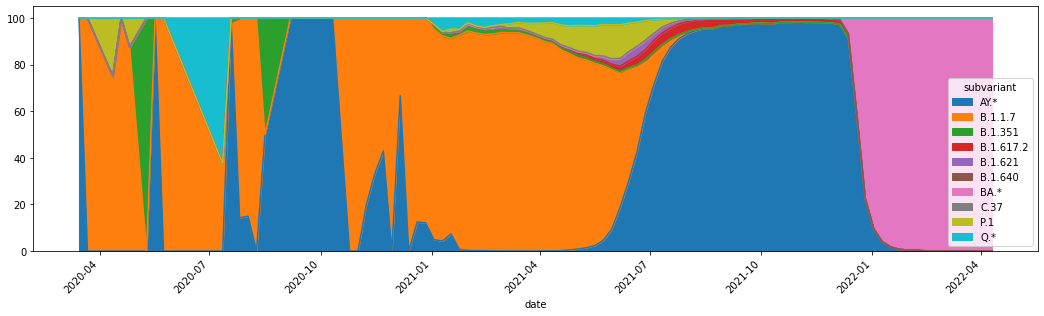

In [49]:
pivot.plot.area(figsize=(18,5), rot=45)